## Demo: Clock check - for offsets in instrument clocks

This is an intermediate step between stage1 and stage 2.  We are trying to determine whether the timestamps for any of the instruments on the same mooring are incorrect.  This is slightly faulty because they could *all* be wrong, unless we are comparing against UTC or have more exact timing knowledge.  For more exact timing knowledge, the deployment time and recovery time (anchor release, either dropping from the ship or release from the seabed) have been added to the yaml file in UTC.  This can be compared against the times estimated through lag correlations.

### This notebook 

**It does not change anything in the data files.**  You run this notebook in order to update the field `clock_offset` (in seconds) in the YAML file for each instrument on a mooring.  This is normally due to the instruments being set up incorrectly (i.e., with a clock time that did not match UTC).

After determining the appropriate clock offset, then run the stage2 processing to apply the clock offset to the netCDF files for each instrument.

Then, running this notebook again using the stage2 files (`*_use.nc`) should predict no additional clock offsets.

Clock offset is in integer seconds ADDED to the original instrument time.  I.e., shifts the record later.

### Main check

- We look at when--according to the instrument clocks--the `temperature` values are cold.  This assumes that in the middle of the record, the temperatures are colder than the near-surface temperatures (may fail for polar deployments).  Cold is within the mean +- 3 * std of the deep values.

- Then check when the instrument first reads a temperature within those bounds: `start_time`
- And check when the instrument last reads a temperature within those bounds: `end_time`

Check whether the first timestamp within the cold water for that instrument is similar in time to the first timestamp for another instrument.  This should be reasonably good at getting large offsets in clocks.

### Secondary check

- We interpolate data onto a common time grid (rough and ready)
- Check for lag correlation between instruments, and use this to estimate an offset

In [14]:
import os

import yaml
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime
import importlib
from oceanarray import find_deployment

from oceanarray import tools

moorlist = ['ds2_X_2012','ds2_X_2017','ds2_X_2018',
            'ds8_1_2012','ds9_1_2012','ds10_1_2012', 'ds11_1_2012','ds12_1_2012',
            'ds13_1_2012','ds14_1_2012','ds15_1_2012','ds16_1_2012','ds17_1_2012',
            'ds19_1_2012','ds18_1_2012','ds28_1_2017',
            'dsA_1_2018','dsB_1_2018','dsC_1_2018', 'dsD_1_2018','dsE_1_2018','dsF_1_2018',
            'dsM1_1_2017','dsM2_1_2017','dsM3_1_2017','dsM4_1_2017','dsM5_1_2017']
moorlist = ['dsE_1_2018']

## Load data for one mooring into datasets, list of xarray datasets

In [15]:
# Specify the base directory.  raw is a subdirectory from here moor/raw/ and proc is moor/proc
basedir = '/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/'
output_path = basedir + 'moor/proc/'

# Toggle to load the *_raw.nc or the *_use.nc
file_subscript = '_raw'
file_subscript = '_use'
print(f"Using files with {file_subscript}")



# Cycle through the yaml and load instrument data into a list of xarray datasets
# Enrich the netCDF with information from the yaml file
# Find the mooring's processed directory & read the yaml specification
name1 = moorlist[0]
proc_dir = output_path + name1
moor_yaml = proc_dir + '/' + name1 + '.mooring.yaml'
with open(moor_yaml, 'r') as f:
    moor_yaml_data = yaml.safe_load(f)

# For each instrument, load the raw netCDF files and add some metadata from the yaml
datasets = []
for i in moor_yaml_data['instruments']:
    fname = name1 + '_' + str(i['serial']) + file_subscript + '.nc'
    rawfile = proc_dir + '/' + i['instrument'] + '/' + fname
    if os.path.exists(rawfile):
        print(rawfile)
        ds1 = xr.open_dataset(rawfile)

        if 'InstrDepth' not in ds1.variables and 'depth' in i:
            ds1['InstrDepth'] = i['depth']
        if 'instrument' not in ds1.variables and 'instrument' in i:
            ds1['instrument'] = i['instrument']
        if 'serial_number' not in ds1.variables and 'serial' in i:
            ds1['serial_number'] = i['serial']
        if 'timeS' in ds1.variables:
            ds1 = ds1.drop_vars('timeS')
        #---------------------------------------------
        # Store the data in a list of datasets
        datasets.append(ds1)


Using files with _use
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6363_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe16/dsE_1_2018_2419_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6401_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6402_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_8482_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6365_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6409_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6397_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6366_use.

# Interpolate dataset

Here we interpolate data onto the same time grid to simply checking for clock offsets (in a later step)

In [16]:
# Collect some timing info for each instrument
intervals_min = []
start_times = []
end_times = []
# For each dataset, write the coverage
for idx, ds in enumerate(datasets):
    time = ds['time']
    start_time = str(time.values[0])
    end_time = str(time.values[-1])
    time_interval = (time.values[1] - time.values[0]) / np.timedelta64(1, 'm')
    time_interval = np.nanmedian(np.diff(time.values) / np.timedelta64(1, 'm') )
    if time_interval > 1:
        tstr = f"{time_interval:1.2f} min"
    else:
        tstr = f"{time_interval * 60:1.2f} sec"
    variables = list(ds.data_vars)
    print(f"Dataset {idx} depth {str(ds['InstrDepth'].values)} [{ds['instrument'].values}:{ds['serial_number'].values}]:")
    print(f"  Start time: {start_time[0:19]}.  End time:   {end_time[0:19]}.  Time interval: {tstr}")
    print(f"  Coordinates: {list(ds.coords)}.  Variables: {variables}")

    #---------------------------------------------
    # Save the interval for later use
    intervals_min.append(time_interval)
    start_times.append(time.values[0])
    end_times.append(time.values[-1])

earliest_start = min(start_times)

end_arr = np.array(end_times, dtype='datetime64[ns]')
mask = ~np.isnat(end_arr)
if mask.any():
    med_ns = np.median(end_arr[mask].astype('int64'))  # median in ns
    latest_end = np.datetime64(int(med_ns), 'ns')
else:
    latest_end = np.datetime64('NaT', 'ns')
earliest_start = pd.to_datetime(start_times).min().to_datetime64()
dt_sec = int(np.nanmedian(intervals_min) * 60)
time_grid = np.arange(earliest_start, latest_end, np.timedelta64(dt_sec, 's'))

#    latest_end = pd.to_datetime(end_times).median()        # pandas.Timestamp
#latest_end = latest_end.to_datetime64()
#latest_end = np.median(np.array(end_times))
#time_grid = np.arange(earliest_start, latest_end, np.timedelta64(int(np.nanmedian(intervals_min) * 60), 's'))

print(f"Time grid length: {len(time_grid)}")
print(f"First time: {time_grid[0]}")
print(f"Last time: {time_grid[-1]}")

Dataset 0 depth 629 [sbe56:6363]:
  Start time: 2018-08-13T12:00:00.  End time:   2018-08-26T10:37:59.  Time interval: 10.02 sec
  Coordinates: ['time', 'latitude', 'longitude'].  Variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number']
Dataset 1 depth 679 [sbe16:2419]:
  Start time: 2018-08-15T11:56:41.  End time:   2018-08-26T10:37:41.  Time interval: 20.00 sec
  Coordinates: ['time'].  Variables: ['temperature', 'salinity', 'conductivity', 'pressure', 'serial_number', 'InstrDepth', 'instrument', 'clock_offset', 'start_time', 'end_time']
Dataset 2 depth 689 [sbe56:6401]:
  Start time: 2018-08-13T11:20:00.  End time:   2018-08-26T10:37:59.  Time interval: 10.02 sec
  Coordinates: ['time', 'latitude', 'longitude'].  Variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number', 'clock_offset']
Dataset 3 depth 699 [sbe56:6402]:
  Start time: 2018-08-13T12:15:50.  End time:   2018-08-26T10:37:59.  Time interval: 10.02 se

Dataset 10 depth 769 [sbe56:6370]:
  Start time: 2018-08-13T11:20:00.  End time:   2018-08-26T10:37:59.  Time interval: 10.02 sec
  Coordinates: ['time', 'latitude', 'longitude'].  Variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number', 'clock_offset']
Dataset 11 depth 790 [tr1050:13889]:
  Start time: 2018-08-13T11:47:00.  End time:   2018-08-26T10:38:00.  Time interval: 10.00 sec
  Coordinates: ['time'].  Variables: ['temperature', 'start_date_time', 'serial_number', 'InstrDepth', 'instrument', 'clock_offset', 'start_time', 'end_time']
Dataset 12 depth 800 [rbrsolo:101651]:
  Start time: 2018-08-13T11:52:50.  End time:   2018-08-26T10:38:00.  Time interval: 10.00 sec
  Coordinates: ['time'].  Variables: ['datasetID', 'temperature', 'serial_number', 'InstrDepth', 'instrument', 'clock_offset', 'start_time', 'end_time']
Dataset 13 depth 810 [tr1050:15580]:
  Start time: 2018-08-13T11:39:30.  End time:   2018-08-26T10:38:00.  Time interval: 10.00 sec

In [17]:
datasets_interp = []
for idx, ds in enumerate(datasets):
    print(f"Dataset {idx}:")
    print(f"  Dimensions: {dict(ds.sizes)},  Coordinates: {list(ds.coords)},  Data variables: {list(ds.data_vars)}")

    # Check if this dataset has a time dimension
    if 'time' not in ds.sizes:
        print(f"  WARNING: Dataset {idx} has no time dimension, skipping interpolation")
        continue

    # Check if time dimension has more than one element
    if ds.sizes['time'] <= 1:
        print(f"  WARNING: Dataset {idx} has only {ds.sizes['time']} time point(s), skipping interpolation")
        continue

    try:
        # Select only the variables present in the dataset that have time dimension
        interp_vars = {}
        for var in ds.data_vars:
            if 'time' in ds[var].dims:
                interp_vars[var] = ds[var].interp(time=time_grid)
            else:
                interp_vars[var] = ds[var]  # Keep variables without time dimension as is

        if interp_vars:  # Only create dataset if we have variables to interpolate
            # Create a new dataset with interpolated variables and replace the time coordinate
            ds_interp = xr.Dataset(interp_vars, coords={'time': time_grid})

            # Add depth and other metadata as coordinates (not variables with time dimension)
            if 'InstrDepth' in ds:
                ds_interp = ds_interp.assign_coords(depth=ds['InstrDepth'])
            if 'clock_offset' in ds:
                ds_interp = ds_interp.assign_coords(seconds_offset=ds['clock_offset'])

            datasets_interp.append(ds_interp)
            #print(f"  Successfully interpolated dataset {idx}")
        else:
            print(f"  No time-dependent variables found in dataset {idx}")

    except Exception as e:
        print(f"  ERROR interpolating dataset {idx}: {e}")
        continue

print(f"\nSuccessfully interpolated {len(datasets_interp)} out of {len(datasets)} datasets")

datasets_interp[0]

Dataset 0:
  Dimensions: {'time': 111829},  Coordinates: ['time', 'latitude', 'longitude'],  Data variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number']
Dataset 1:
  Dimensions: {'time': 47284},  Coordinates: ['time'],  Data variables: ['temperature', 'salinity', 'conductivity', 'pressure', 'serial_number', 'InstrDepth', 'instrument', 'clock_offset', 'start_time', 'end_time']
Dataset 2:
  Dimensions: {'time': 112069},  Coordinates: ['time', 'latitude', 'longitude'],  Data variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number', 'clock_offset']
Dataset 3:
  Dimensions: {'time': 111734},  Coordinates: ['time', 'latitude', 'longitude'],  Data variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number', 'clock_offset']
Dataset 4:
  Dimensions: {'time': 116604},  Coordinates: ['time', 'latitude', 'longitude'],  Data variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'inst

<xarray.Dataset> Size: 3MB
Dimensions:             (time: 116604)
Coordinates:
    latitude            float32 4B ...
    longitude           float32 4B ...
  * time                (time) datetime64[ns] 933kB 2018-08-12T22:44:08.97920...
    depth               int64 8B 629
Data variables:
    temperature         (time) float64 933kB nan nan nan ... 5.008 5.008 5.009
    julian_days_offset  (time) float64 933kB nan nan nan ... 237.4 237.4 237.4
    InstrDepth          int64 8B 629
    instrument          <U5 20B 'sbe56'
    serial_number       int64 8B 6363

# Combine interpolated datasets

In [18]:
# List of variables to keep
vars_to_keep = ['temperature', 'salinity', 'conductivity', 'pressure', 'u_velocity','v_velocity']#,'serial_number','InstrDepth']

# Remove unwanted variables from each dataset
datasets_clean = []
for ds in datasets_interp:
    ds_sel = ds.drop_vars(['density', 'potential_temperature', 'julian_days_offset','timeS'], errors='ignore')
    datasets_clean.append(ds_sel)

# Find union of all time coordinates (should be the same for all, but let's check)
time_coord = datasets_interp[0]['time']

# Prepare data arrays for each variable
combined_data = {}
N_LEVELS = len(datasets_clean)

for var in vars_to_keep:
    arrs = []
    for ds in datasets_clean:
        if var in ds:
            arrs.append(ds[var].values)
        else:
            arrs.append(np.full(time_coord.shape, np.nan))
    # Stack along new N_LEVELS dimension
    combined_data[var] = (('time', 'N_LEVELS'), np.stack(arrs, axis=-1))

# Gather scalar variables for each level
depths = []
clock_offsets = []
serial = []
instrtype = []
for ds in datasets_clean:
    # depth: if missing, use NaN
    depths.append(float(ds["InstrDepth"].item()) if "InstrDepth" in ds else np.nan)
    serial.append(ds['serial_number'].item() if "serial_number" in ds else np.nan)
    instrtype.append(ds['instrument'].item() if "instrument" in ds else 'unknown'  )
    # clock offset: prefer 'clock_offset', fall back to legacy 'seconds_offset', else 0
    if "clock_offset" in ds:
        co = ds["clock_offset"].item()
    elif "seconds_offset" in ds:
        co = ds["seconds_offset"].item()
    else:
        co = 0
    # cast safely; NaN -> 0
    clock_offsets.append(int(np.rint(co)) if np.isfinite(co) else 0)

# Create the combined dataset
combined_ds = xr.Dataset(
    data_vars=combined_data,
    coords={
        'time': time_coord,
        'N_LEVELS': np.arange(N_LEVELS),
        'clock_offset': ('N_LEVELS', np.array(clock_offsets)),
        'serial_number': ('N_LEVELS', np.array(serial)),
        'nominal_depth': ('N_LEVELS', np.array(depths)),
        "instrument": ("N_LEVELS", np.asarray(instrtype)),  # <-- 1-D


    }
)


combined_ds

<xarray.Dataset> Size: 124MB
Dimensions:        (time: 116604, N_LEVELS: 22)
Coordinates:
    latitude       float32 4B ...
    longitude      float32 4B ...
  * time           (time) datetime64[ns] 933kB 2018-08-12T22:44:08.979200 ......
    depth          int64 8B 629
  * N_LEVELS       (N_LEVELS) int64 176B 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
    clock_offset   (N_LEVELS) int64 176B 0 259000 -2400 950 ... 84420 -2050 -200
    serial_number  (N_LEVELS) int64 176B 6363 2419 6401 6402 ... 15577 7518 6364
    nominal_depth  (N_LEVELS) float64 176B 629.0 679.0 689.0 ... 880.0 905.0
    instrument     (N_LEVELS) <U8 704B 'sbe56' 'sbe16' ... 'microcat' 'sbe56'
Data variables:
    temperature    (time, N_LEVELS) float64 21MB nan nan nan ... 4.033 nan 3.78
    salinity       (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    conductivity   (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    pressure       (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    u_velocity     (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    v_velocity     (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan

In [19]:
ds

<xarray.Dataset> Size: 2MB
Dimensions:         (time: 116604)
Coordinates:
    latitude        float32 4B ...
    longitude       float32 4B ...
  * time            (time) datetime64[ns] 933kB 2018-08-12T22:44:08.979200 .....
    depth           int64 8B 905
    seconds_offset  int64 8B ...
Data variables:
    temperature     (time) float64 933kB nan nan nan nan ... 3.783 3.772 3.78
    InstrDepth      int64 8B 905
    instrument      <U5 20B 'sbe56'
    serial_number   int64 8B 6364
    clock_offset    int64 8B -200

## Identify likely start and end of DEPLOYED period (on the bottom)

In [20]:
importlib.reload(find_deployment)

combined_ds = find_deployment.find_deployment(combined_ds,bottom_strategy="deployment_bounds")


My time starts at 2018-08-12T22:44:08.979200000
recovery time is 2018-08-26T10:37:58.979200000
My start is 2018-08-12 22:44:08.979200 and end is 2018-08-26 10:37:58.979200
My bot_start is 2018-08-13T00:44:08.979200000 and bot_end is 2018-08-26T08:37:58.979200000
My sea_mean is 4.806291913064397 and std is 3.0097981957601063
0/6363:sbe56: Split at 9.32.  Start after 2018-08-13T22:46:38.979200000.  End with 2018-08-26T10:37:58.979200000.
recovery time is 2018-08-26T10:37:58.979200000
My start is 2018-08-12 22:44:08.979200 and end is 2018-08-26 10:37:58.979200
My bot_start is 2018-08-13T00:44:08.979200000 and bot_end is 2018-08-26T08:37:58.979200000
My sea_mean is 4.177342382049964 and std is 2.306556088604992
1/2419:sbe16: Split at 7.64.  Start after 2018-08-15T22:42:38.979200000.  End with 2018-08-26T10:37:38.979200000.
recovery time is 2018-08-26T10:37:58.979200000
My start is 2018-08-12 22:44:08.979200 and end is 2018-08-26 10:37:58.979200
My bot_start is 2018-08-13T00:44:08.979200000

/Users/eddifying/Cloudfree/github/oceanarray/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


4/8482:sbe56: Split at 11.19.  Start after 2018-08-13T21:39:48.979200000.  End with 2018-08-26T10:37:58.979200000.
recovery time is 2018-08-26T10:37:58.979200000
My start is 2018-08-12 22:44:08.979200 and end is 2018-08-26 10:37:58.979200
My bot_start is 2018-08-13T00:44:08.979200000 and bot_end is 2018-08-26T08:37:58.979200000
My sea_mean is 3.935424072919649 and std is 3.200858622369658
5/6365:sbe56: Split at 8.74.  Start after 2018-08-13T22:46:08.979200000.  End with 2018-08-26T10:37:58.979200000.
recovery time is 2018-08-26T10:37:58.979200000
My start is 2018-08-12 22:44:08.979200 and end is 2018-08-26 10:37:58.979200
My bot_start is 2018-08-13T00:44:08.979200000 and bot_end is 2018-08-26T08:37:58.979200000
My sea_mean is 3.8252264552683832 and std is 3.22398053897293
6/6409:sbe56: Split at 8.66.  Start after 2018-08-13T22:46:08.979200000.  End with 2018-08-26T10:37:58.979200000.
recovery time is 2018-08-26T10:37:58.979200000
My start is 2018-08-12 22:44:08.979200 and end is 2018-0

/Users/eddifying/Cloudfree/github/oceanarray/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


19/15577:tr1050: Split at 7.24.  Start after 2018-08-13T22:14:18.979200000.  End with 2018-08-26T10:37:58.979200000.
recovery time is 2018-08-26T10:37:58.979200000
My start is 2018-08-12 22:44:08.979200 and end is 2018-08-26 10:37:58.979200
My bot_start is 2018-08-13T00:44:08.979200000 and bot_end is 2018-08-26T08:37:58.979200000
My sea_mean is 2.4421379821079503 and std is 4.058823647071597
20/7518:microcat: Split at 8.53.  Start after 2018-08-13T22:11:28.979200000.  End with 2018-08-26T10:37:48.979200000.
recovery time is 2018-08-26T10:37:58.979200000
My start is 2018-08-12 22:44:08.979200 and end is 2018-08-26 10:37:58.979200
My bot_start is 2018-08-13T00:44:08.979200000 and bot_end is 2018-08-26T08:37:58.979200000
My sea_mean is 2.0986859020637767 and std is 3.237379169526099
21/6364:sbe56: Split at 6.95.  Start after 2018-08-13T22:42:08.979200000.  End with 2018-08-26T10:37:58.979200000.


In [21]:
combined_ds

<xarray.Dataset> Size: 124MB
Dimensions:        (time: 116604, N_LEVELS: 22)
Coordinates:
    latitude       float32 4B ...
    longitude      float32 4B ...
  * time           (time) datetime64[ns] 933kB 2018-08-12T22:44:08.979200 ......
    depth          int64 8B 629
  * N_LEVELS       (N_LEVELS) int64 176B 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
    clock_offset   (N_LEVELS) int64 176B 0 259000 -2400 950 ... 84420 -2050 -200
    serial_number  (N_LEVELS) int64 176B 6363 2419 6401 6402 ... 15577 7518 6364
    nominal_depth  (N_LEVELS) float64 176B 629.0 679.0 689.0 ... 880.0 905.0
    instrument     (N_LEVELS) <U8 704B 'sbe56' 'sbe16' ... 'microcat' 'sbe56'
Data variables:
    temperature    (time, N_LEVELS) float64 21MB nan nan nan ... 4.033 nan 3.78
    salinity       (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    conductivity   (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    pressure       (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    u_velocity     (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    v_velocity     (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    start_time     (N_LEVELS) datetime64[ns] 176B 2018-08-13T22:46:38.979200 ...
    end_time       (N_LEVELS) datetime64[ns] 176B 2018-08-26T10:37:58.979200 ...
    split_value    (N_LEVELS) float64 176B 9.321 7.637 8.988 ... 8.53 6.955

## Plot all the time series of temperature

start time is 2018-08-13T22:46:38.979200000


/var/folders/t1/z5bp59k95119nw35yqv699t40000gn/T/ipykernel_72908/2312768844.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in range(ds.dims["N_LEVELS"]):


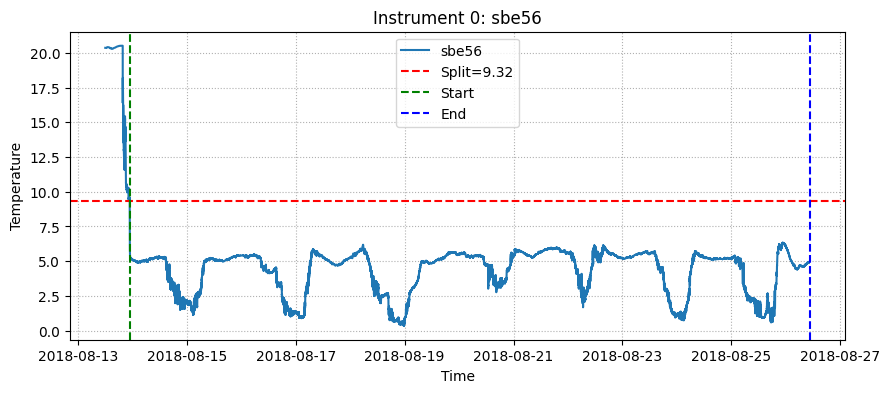

start time is 2018-08-15T22:42:38.979200000


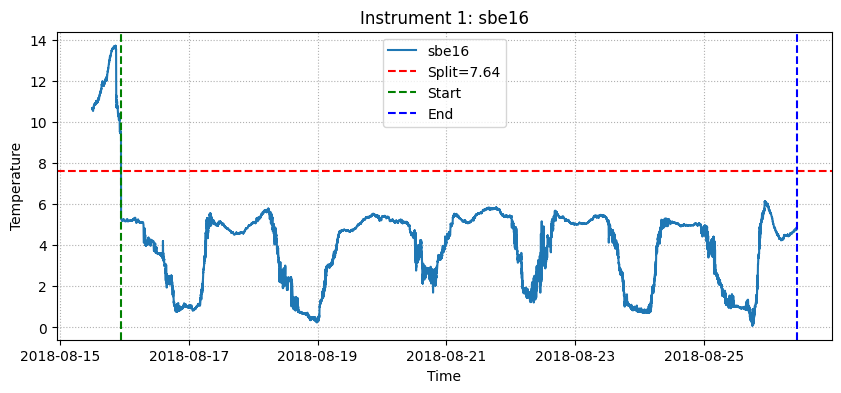

start time is 2018-08-13T22:06:18.979200000


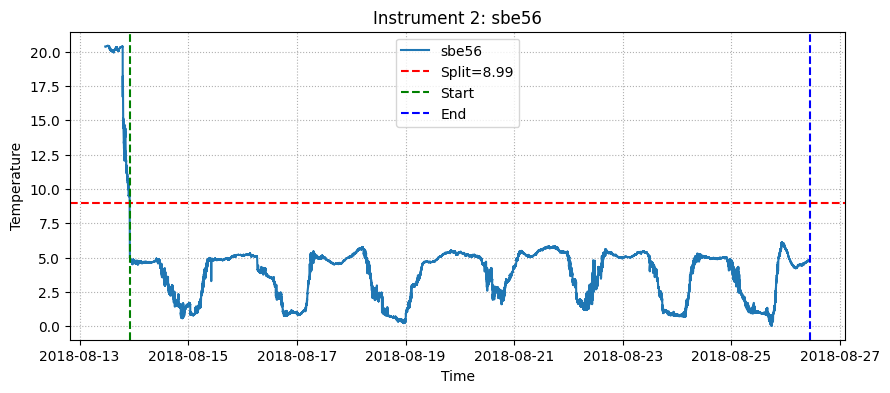

start time is 2018-08-13T23:01:58.979200000


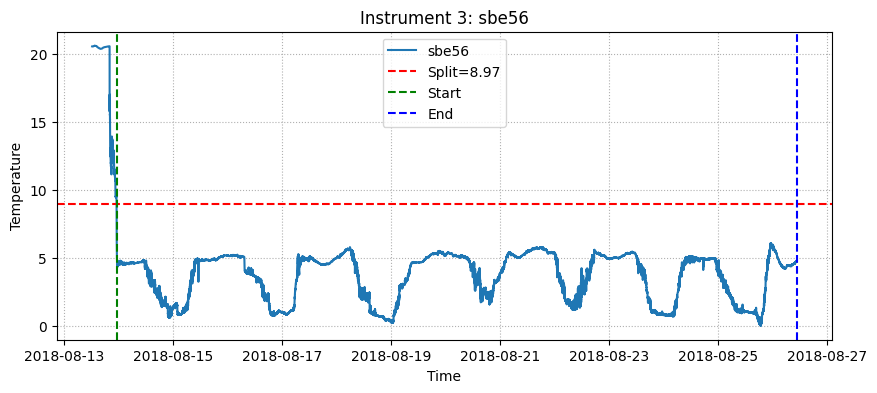

start time is 2018-08-13T21:39:48.979200000


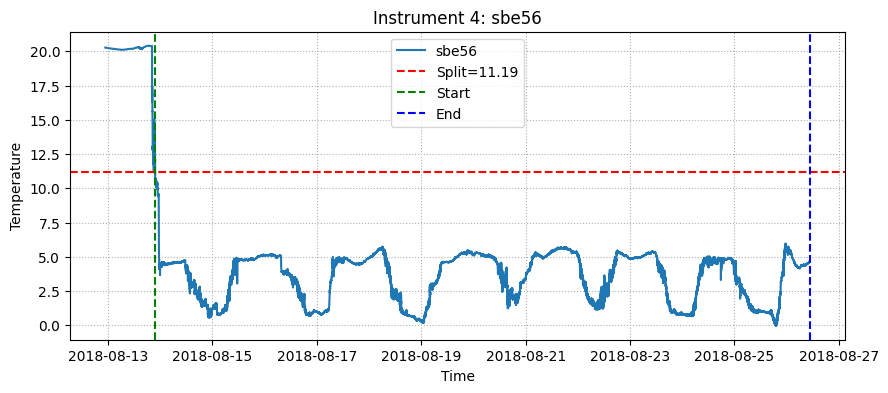

start time is 2018-08-13T22:46:08.979200000


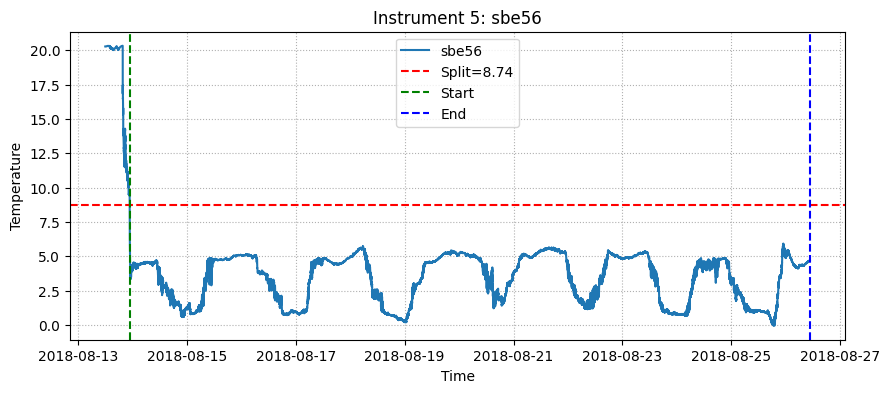

start time is 2018-08-13T22:46:08.979200000


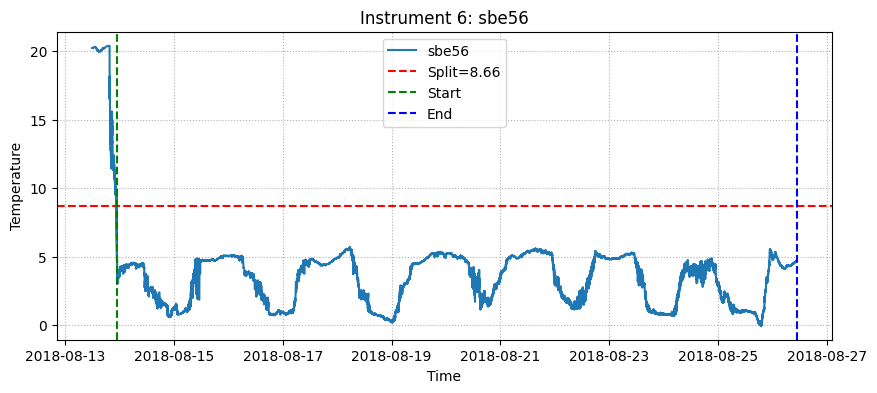

start time is 2018-08-13T22:05:58.979200000


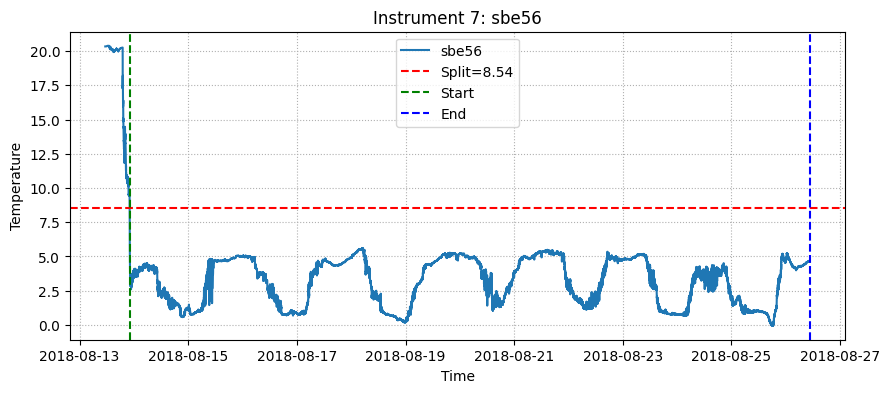

start time is 2018-08-13T22:05:58.979200000


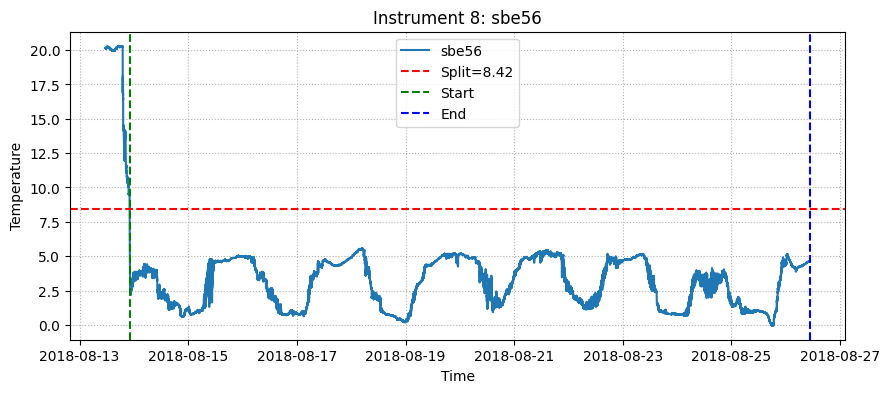

start time is 2018-08-13T22:05:58.979200000


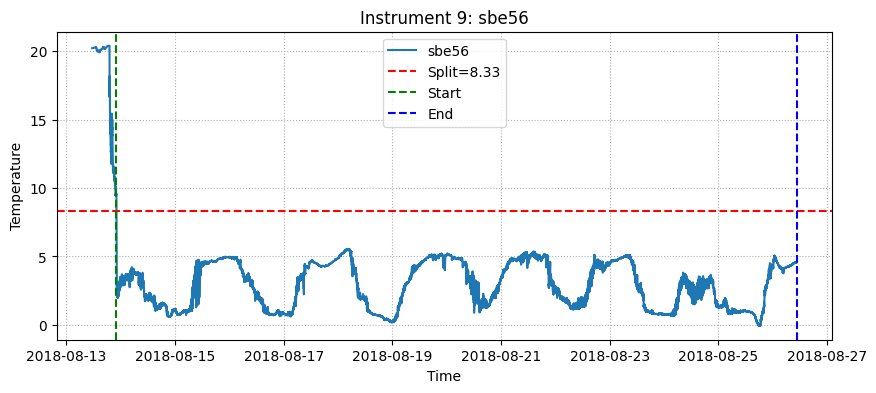

start time is 2018-08-13T22:05:48.979200000


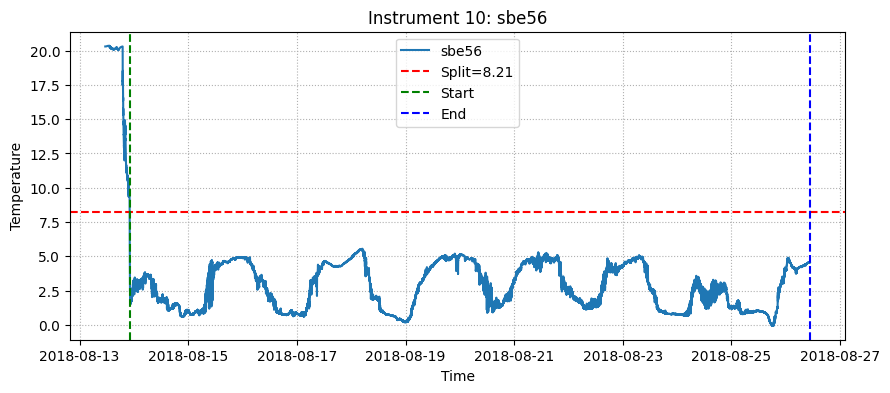

start time is 2018-08-13T22:34:08.979200000


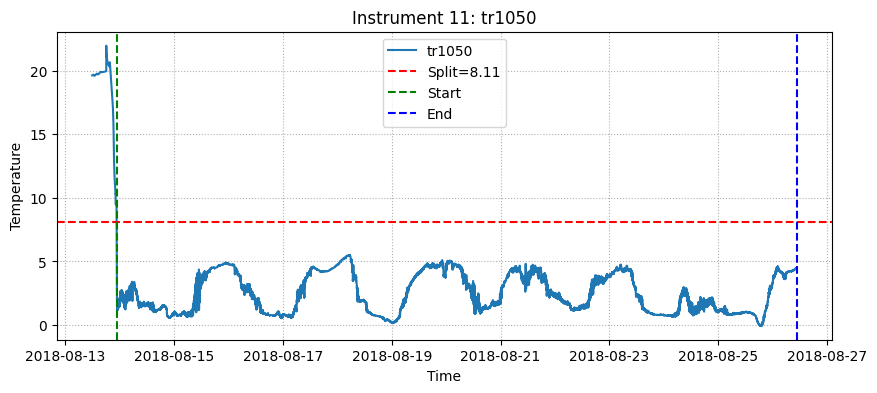

start time is 2018-08-13T22:39:38.979200000


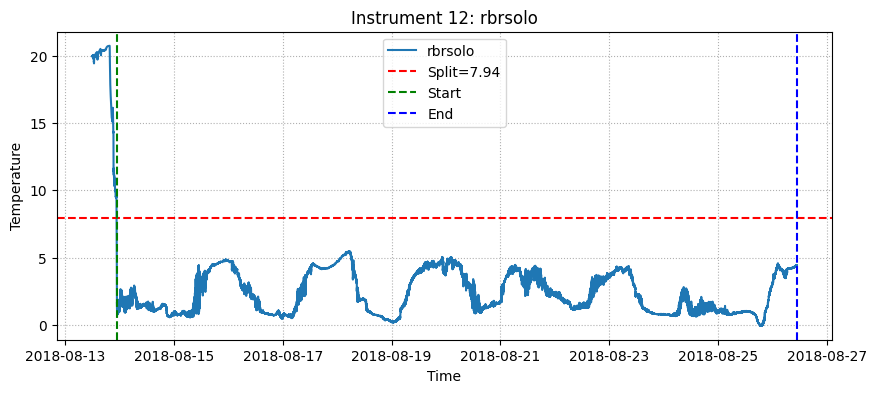

start time is 2018-08-13T22:26:48.979200000


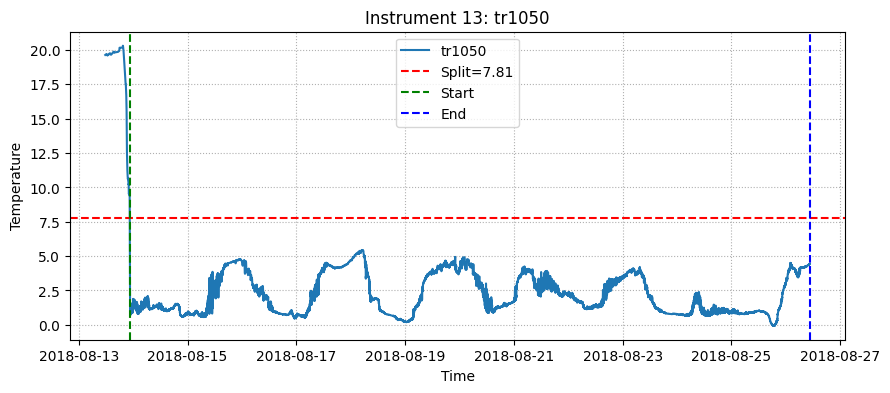

start time is 2018-08-13T22:38:48.979200000


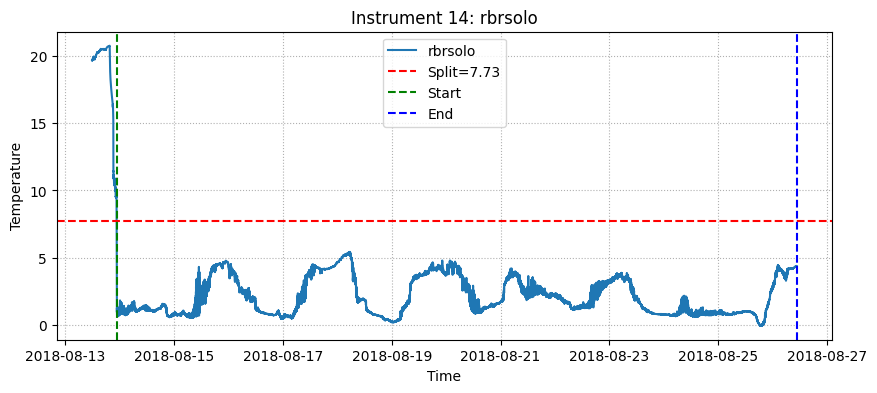

start time is 2018-08-13T16:19:48.979200000


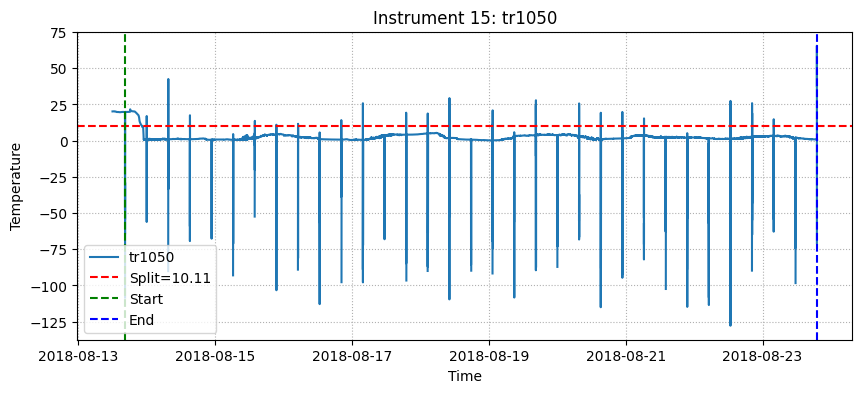

start time is 2018-08-13T22:37:38.979200000


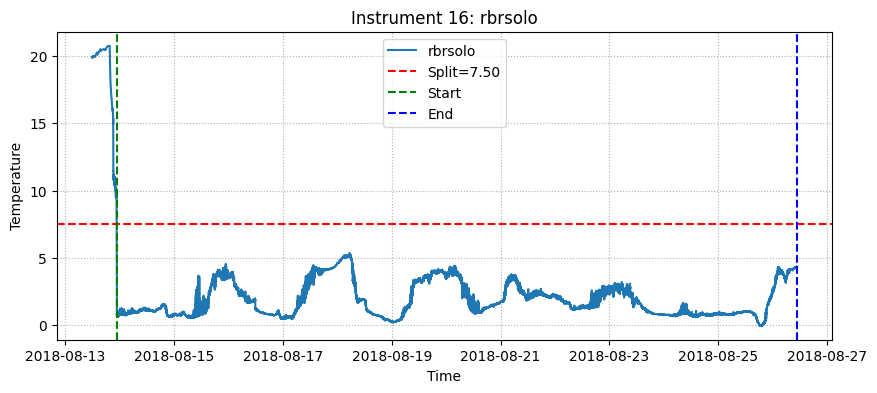

start time is 2018-08-13T22:39:18.979200000


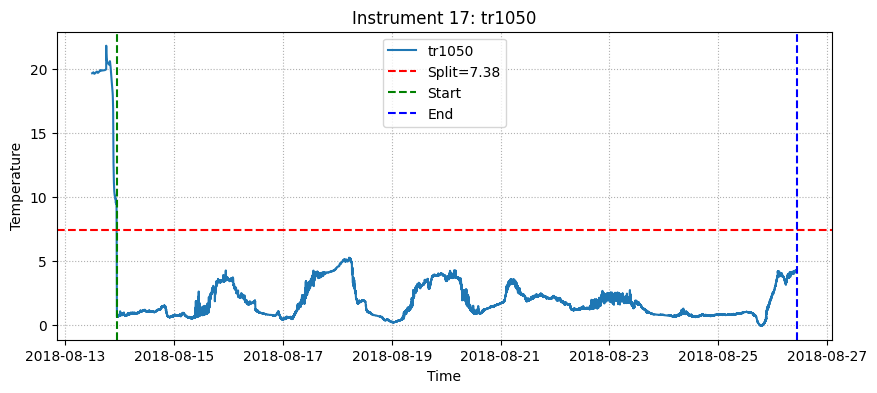

start time is 2018-08-13T22:28:38.979200000


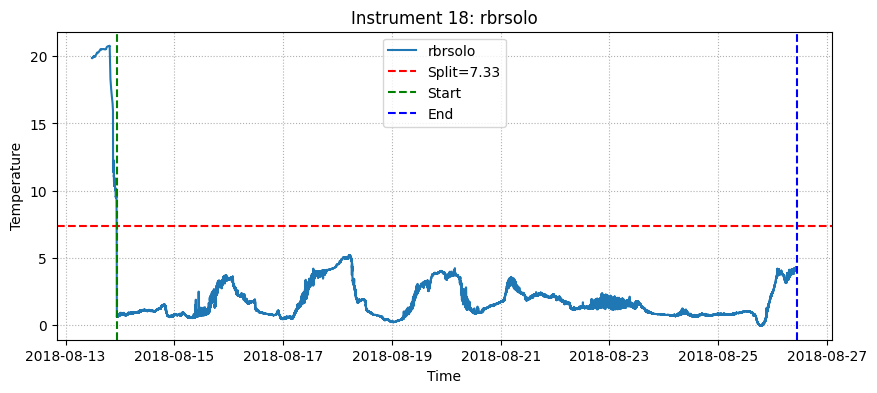

start time is 2018-08-13T22:14:18.979200000


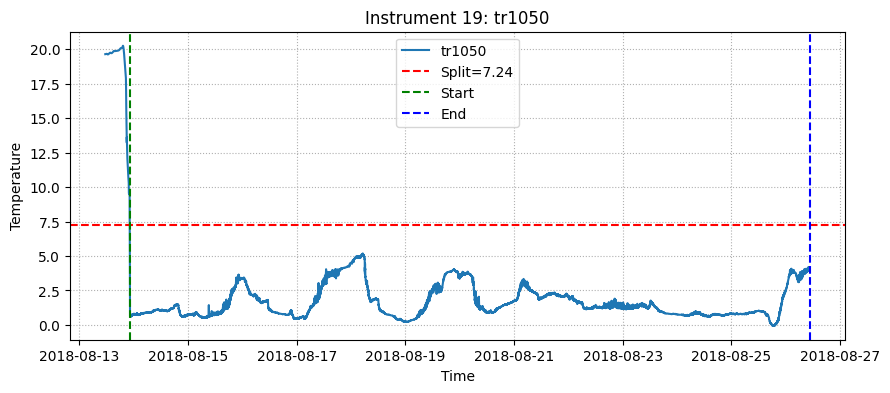

start time is 2018-08-13T22:11:28.979200000


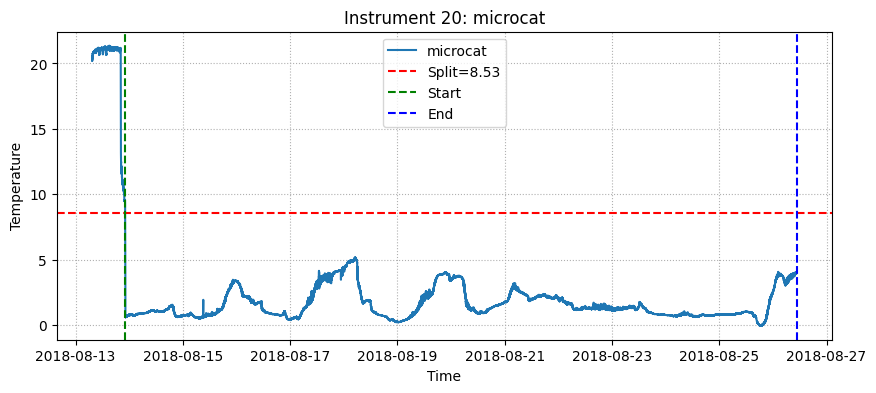

start time is 2018-08-13T22:42:08.979200000


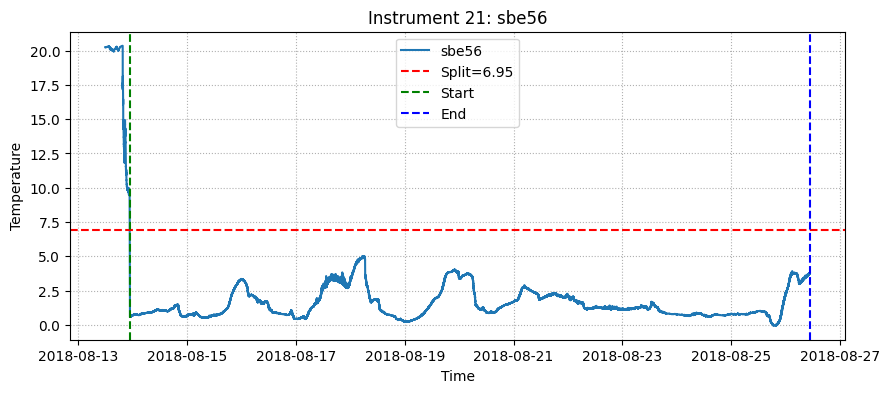

In [22]:
import matplotlib.pyplot as plt
ds = combined_ds
time        = ds["time"].values
temp        = ds["temperature"].values
split_vals  = ds["split_value"].values
instruments = ds["instrument"].values
start_times = ds["start_time"].values
end_times   = ds["end_time"].values

#for i in range(0,1):
for i in range(ds.dims["N_LEVELS"]):
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(time, temp[:, i], label=f"{instruments[i]}")
    ax.axhline(split_vals[i], color="red", linestyle="--",
               label=f"Split={split_vals[i]:.2f}")

    # vertical lines for start/end times (if not NaT)
    if np.isfinite(start_times[i].astype("datetime64[ns]").astype("int64")):
        ax.axvline(start_times[i], color="green", linestyle="--", lw=1.5,
                   label="Start")
        print(f"start time is {start_times[i]}")
    if np.isfinite(end_times[i].astype("datetime64[ns]").astype("int64")):
        ax.axvline(end_times[i], color="blue", linestyle="--", lw=1.5,
                   label="End")


    ax.set_title(f"Instrument {i}: {instruments[i]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature")
    ax.legend()
    ax.grid(True, linestyle=":")

    plt.show()


## Create a table of start/end and offset

Use the **negative** of the offset as the clock_offset in the yaml

In [23]:
import numpy as np
import pandas as pd

ds = combined_ds  # or your dataset

# --- pull times ---
start_times = pd.to_datetime(ds["start_time"].values)
end_times   = pd.to_datetime(ds["end_time"].values)

# finite masks
f_start = np.isfinite(start_times)
f_end   = np.isfinite(end_times)

# --- initial refs (global) just to compute provisional offsets for clustering ---
ref_start0 = start_times[f_start].min()
ref_end0   = end_times[f_end].max()

start_off0 = np.full(start_times.shape, np.nan, float)
end_off0   = np.full(end_times.shape,   np.nan, float)
start_off0[f_start] = (start_times[f_start] - ref_start0) / np.timedelta64(1, "s")
end_off0[f_end]     = (end_times[f_end]   - ref_end0)     / np.timedelta64(1, "s")

# --- consensus group on start offsets (bin to nearest 60 s) ---
bin_width = 60.0  # seconds
vals = start_off0[np.isfinite(start_off0)]
if vals.size == 0:
    raise RuntimeError("No finite start offsets to form consensus.")

vmin, vmax = vals.min(), vals.max()
bins = np.arange(vmin - bin_width, vmax + 2*bin_width, bin_width)
hist, edges = np.histogram(vals, bins=bins)
k = np.argmax(hist)
lo, hi = edges[k], edges[k+1]
in_consensus = (start_off0 >= lo) & (start_off0 < hi)

idx_consensus = np.where(in_consensus & f_start & f_end)[0]  # require both times finite
if idx_consensus.size == 0:
    # fallback: use all in the winning bin even if some lack end_times
    idx_consensus = np.where(in_consensus & f_start)[0]
# --- redefine refs from consensus group only ---
ref_start = start_times[idx_consensus].min()
ref_end   = end_times[idx_consensus].max()

# --- recompute offsets relative to NEW refs ---
start_off = (start_times - ref_start) / np.timedelta64(1, "s")
end_off   = (end_times   - ref_end)   / np.timedelta64(1, "s")
avg_off   = (start_off + end_off) / 2.0
diff_off  = start_off - end_off       # start vs end disagreement (drift hint)

# --- optional: drift rate (s/day), skip ones without both times ---
dur = (end_times - start_times) / np.timedelta64(1, "s")
drift_rate_per_day = np.full_like(avg_off, np.nan, dtype=float)
ok = np.isfinite(start_off) & np.isfinite(end_off) & np.isfinite(dur) & (dur > 0)
drift_rate_per_day[ok] = (end_off[ok] - start_off[ok]) / dur[ok] * 86400.0

# --- print summary ---
N = ds.sizes["N_LEVELS"]
labels = ds["instrument"].values if "instrument" in ds else np.arange(N)
serial = ds["serial_number"].values if "serial_number" in ds else "0"
print(f"Consensus group size: {idx_consensus.size}")
print(f"Consensus-derived refs -> ref_start={ref_start}, ref_end={ref_end}\n")

for i in range(N):
    tag = "REF" if i in idx_consensus else "-"
    s = start_off[i]; e = end_off[i]; a = avg_off[i]; d = diff_off[i]; dr = drift_rate_per_day[i]
    print(
        f"{i:02d}: {str(labels[i]):8s}/{str(serial[i]):6s} | "
        f"start={pd.to_datetime(start_times[i])} ({s:+8.0f}s) | "
        f"end={pd.to_datetime(end_times[i])} ({e:+8.0f}s) | "
        f"avg={a:+8.0f}s | diff={d:+6.0f}s | drift={'nan' if not np.isfinite(dr) else f'{dr:+.2f} s/day'} | {tag}"
    )


Consensus group size: 5
Consensus-derived refs -> ref_start=2018-08-13 22:05:48.979200, ref_end=2018-08-26 10:37:58.979200

00: sbe56   /6363   | start=2018-08-13 22:46:38.979200 (   +2450s) | end=2018-08-26 10:37:58.979200 (      +0s) | avg=   +1225s | diff= +2450s | drift=-196.09 s/day | -
01: sbe16   /2419   | start=2018-08-15 22:42:38.979200 ( +175010s) | end=2018-08-26 10:37:38.979200 (     -20s) | avg=  +87495s | diff=+175030s | drift=-16675.04 s/day | -
02: sbe56   /6401   | start=2018-08-13 22:06:18.979200 (     +30s) | end=2018-08-26 10:37:58.979200 (      +0s) | avg=     +15s | diff=   +30s | drift=-2.40 s/day | REF
03: sbe56   /6402   | start=2018-08-13 23:01:58.979200 (   +3370s) | end=2018-08-26 10:37:58.979200 (      +0s) | avg=   +1685s | diff= +3370s | drift=-269.96 s/day | -
04: sbe56   /8482   | start=2018-08-13 21:39:48.979200 (   -1560s) | end=2018-08-26 10:37:58.979200 (      +0s) | avg=    -780s | diff= -1560s | drift=+124.40 s/day | -
05: sbe56   /6365   | start=

In [24]:
combined_ds

<xarray.Dataset> Size: 124MB
Dimensions:        (time: 116604, N_LEVELS: 22)
Coordinates:
    latitude       float32 4B ...
    longitude      float32 4B ...
  * time           (time) datetime64[ns] 933kB 2018-08-12T22:44:08.979200 ......
    depth          int64 8B 629
  * N_LEVELS       (N_LEVELS) int64 176B 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
    clock_offset   (N_LEVELS) int64 176B 0 259000 -2400 950 ... 84420 -2050 -200
    serial_number  (N_LEVELS) int64 176B 6363 2419 6401 6402 ... 15577 7518 6364
    nominal_depth  (N_LEVELS) float64 176B 629.0 679.0 689.0 ... 880.0 905.0
    instrument     (N_LEVELS) <U8 704B 'sbe56' 'sbe16' ... 'microcat' 'sbe56'
Data variables:
    temperature    (time, N_LEVELS) float64 21MB nan nan nan ... 4.033 nan 3.78
    salinity       (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    conductivity   (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    pressure       (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    u_velocity     (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    v_velocity     (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    start_time     (N_LEVELS) datetime64[ns] 176B 2018-08-13T22:46:38.979200 ...
    end_time       (N_LEVELS) datetime64[ns] 176B 2018-08-26T10:37:58.979200 ...
    split_value    (N_LEVELS) float64 176B 9.321 7.637 8.988 ... 8.53 6.955

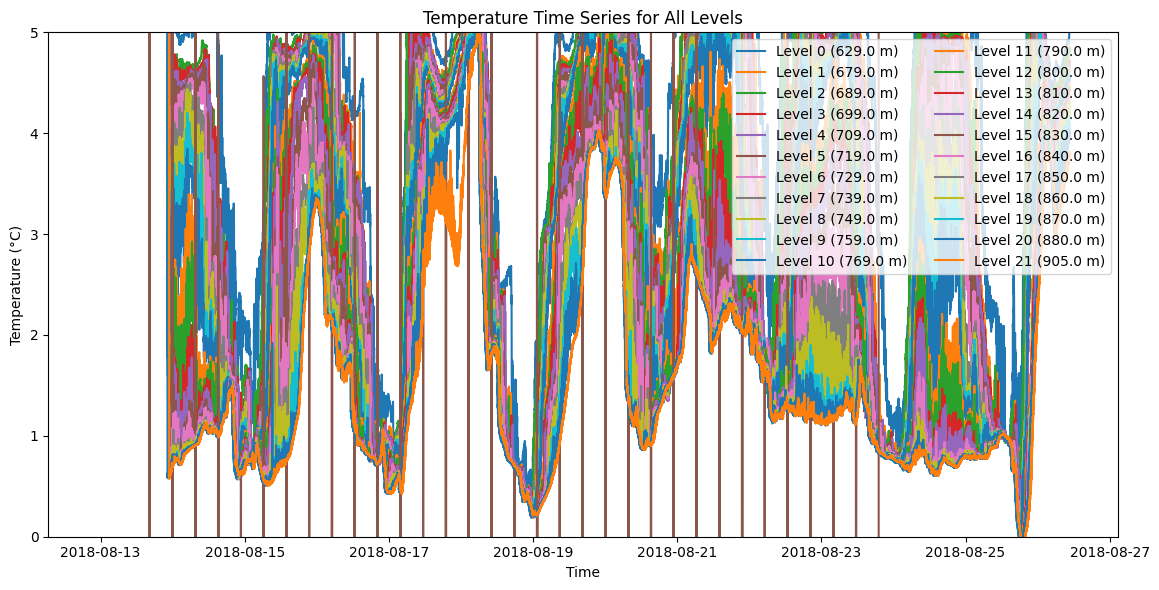

In [25]:
# Trim combined_ds to the period between start_time and end_time
#combined_ds
#combined_ds = combined_ds.where(combined_ds['time']>combined_ds.attrs['start_time'], drop=True)
#combined_ds = combined_ds.where(combined_ds['time']<combined_ds.attrs['end_time'], drop=True)


# Plot a basic variable
time_interval = np.nanmedian(np.diff(combined_ds['time'].values) / np.timedelta64(1, 'm'))

plt.figure(figsize=(12, 6))
for i in range(combined_ds.sizes['N_LEVELS']):
    plt.plot(combined_ds['time'], combined_ds['temperature'][:, i], label=f'Level {i} ({depths[i]} m)')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Time Series for All Levels')
plt.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.ylim(0,5)
plt.show()


Full length is 116604.  Subsampled length is 23321.
Level 1 (#6363): max corr = 0.972 @lag 0 --> clock_offset (sec): 0.0 + 0 = 0.0s
Level 2 (#2419): max corr = 0.802 @lag 4 --> clock_offset (sec): 200.0 + 259000 = 259200.0s
Level 3 (#6401): max corr = 0.995 @lag 48 --> clock_offset (sec): 2400.0 + -2400 = 0.0s
Level 4 (#6402): max corr = 0.997 @lag -19 --> clock_offset (sec): -950.0 + 950 = 0.0s
Level 5 (#8482): max corr = 0.999 @lag -40 --> clock_offset (sec): -2000.0 + 2000 = 0.0s
Level 6 (#6365): max corr = 1.000 @lag 0 --> clock_offset (sec): 0.0 + 0 = 0.0s
Level 7 (#6409): max corr = 0.999 @lag 0 --> clock_offset (sec): 0.0 + 0 = 0.0s
Level 8 (#6397): max corr = 0.996 @lag 48 --> clock_offset (sec): 2400.0 + -2400 = 0.0s
Level 9 (#6366): max corr = 0.992 @lag 48 --> clock_offset (sec): 2400.0 + -2400 = 0.0s
Level 10 (#6394): max corr = 0.987 @lag 48 --> clock_offset (sec): 2400.0 + -2400 = 0.0s
Level 11 (#6370): max corr = 0.980 @lag 48 --> clock_offset (sec): 2400.0 + -2400 = 0.0

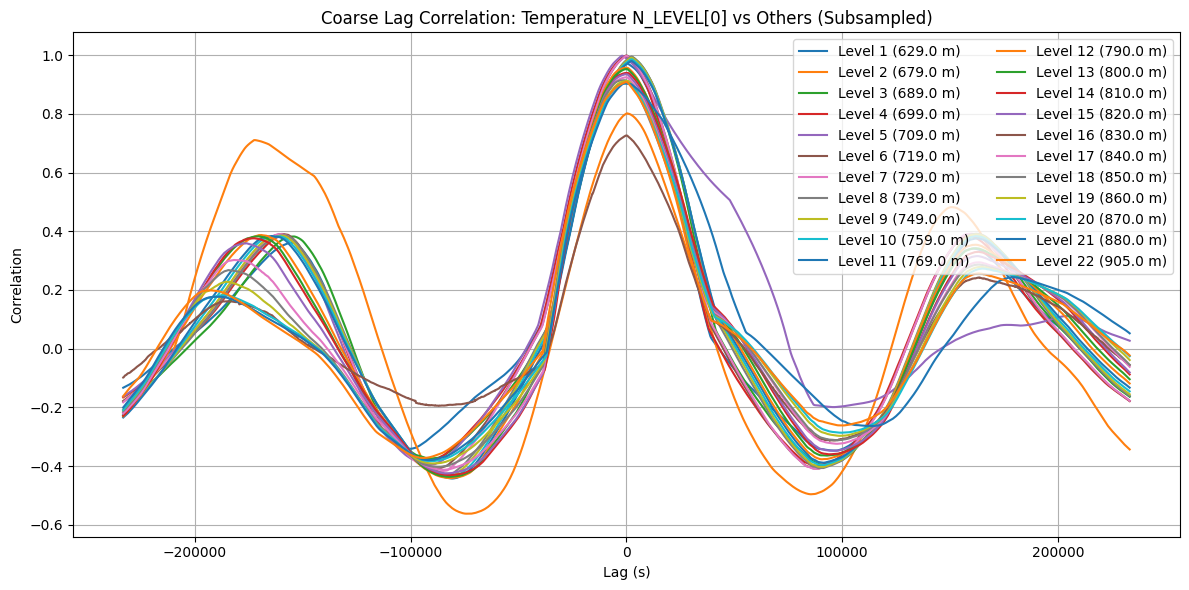

In [26]:
import importlib
importlib.reload(tools)
time_interval = np.nanmedian(np.diff(combined_ds['time'].values) / np.timedelta64(1, 's'))

# Subsample time series
sub_sample = 5


ref_index = 5

n_full = len(combined_ds['temperature'][:, ref_index].values)
ref_temp_sub = combined_ds['temperature'][:, ref_index].values[::sub_sample]
n_sub = len(ref_temp_sub)
print(f"Full length is {n_full}.  Subsampled length is {n_sub}.")

max_lag_sub = n_sub // 5
max_lag_sub = n_sub // 5
lags_sub = np.arange(-max_lag_sub, max_lag_sub + 1)
lags = []
plt.figure(figsize=(12, 6))

for i in range(0, N_LEVELS):
    serial = combined_ds['serial_number'][i].values
    temp_i_sub = combined_ds['temperature'][:, i].values[::sub_sample]
    coff = combined_ds['clock_offset'][i].values
    corrs_sub = tools.lag_correlation(ref_temp_sub, temp_i_sub, max_lag_sub)
    # Find maximum correlation and corresponding lag
    max_corr_idx = np.nanargmax(corrs_sub)
    max_corr = corrs_sub[max_corr_idx]
    max_lag = lags_sub[max_corr_idx]
    dt_sub = sub_sample * time_interval
    print(f"Level {i+1} (#{serial}): max corr = {max_corr:.3f} @lag {max_lag} --> clock_offset (sec): {max_lag*dt_sub} + {coff} = {max_lag*dt_sub+coff}s")
    plt.plot(lags_sub*dt_sub, corrs_sub, label=f'Level {i+1} ({depths[i]} m)')

    lags.append(max_lag)

combined_ds['lags'] = ('N_LEVELS', lags)
print(f"Enter the summed value, no sign change, in the yaml as clock_offset: XXXX")

plt.xlabel('Lag (s)')
plt.ylabel('Correlation')
plt.title('Coarse Lag Correlation: Temperature N_LEVEL[0] vs Others (Subsampled)')
plt.legend(loc='upper right', ncol=2)
plt.grid()
plt.tight_layout()
plt.show()


In [27]:
combined_ds


<xarray.Dataset> Size: 124MB
Dimensions:        (time: 116604, N_LEVELS: 22)
Coordinates:
    latitude       float32 4B ...
    longitude      float32 4B ...
  * time           (time) datetime64[ns] 933kB 2018-08-12T22:44:08.979200 ......
    depth          int64 8B 629
  * N_LEVELS       (N_LEVELS) int64 176B 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
    clock_offset   (N_LEVELS) int64 176B 0 259000 -2400 950 ... 84420 -2050 -200
    serial_number  (N_LEVELS) int64 176B 6363 2419 6401 6402 ... 15577 7518 6364
    nominal_depth  (N_LEVELS) float64 176B 629.0 679.0 689.0 ... 880.0 905.0
    instrument     (N_LEVELS) <U8 704B 'sbe56' 'sbe16' ... 'microcat' 'sbe56'
Data variables:
    temperature    (time, N_LEVELS) float64 21MB nan nan nan ... 4.033 nan 3.78
    salinity       (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    conductivity   (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    pressure       (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    u_velocity     (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    v_velocity     (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    start_time     (N_LEVELS) datetime64[ns] 176B 2018-08-13T22:46:38.979200 ...
    end_time       (N_LEVELS) datetime64[ns] 176B 2018-08-26T10:37:58.979200 ...
    split_value    (N_LEVELS) float64 176B 9.321 7.637 8.988 ... 8.53 6.955
    lags           (N_LEVELS) int64 176B 0 4 48 -19 -40 0 0 ... 1 -26 8 -4 -8 0

In [28]:
combined_ds

<xarray.Dataset> Size: 124MB
Dimensions:        (time: 116604, N_LEVELS: 22)
Coordinates:
    latitude       float32 4B ...
    longitude      float32 4B ...
  * time           (time) datetime64[ns] 933kB 2018-08-12T22:44:08.979200 ......
    depth          int64 8B 629
  * N_LEVELS       (N_LEVELS) int64 176B 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
    clock_offset   (N_LEVELS) int64 176B 0 259000 -2400 950 ... 84420 -2050 -200
    serial_number  (N_LEVELS) int64 176B 6363 2419 6401 6402 ... 15577 7518 6364
    nominal_depth  (N_LEVELS) float64 176B 629.0 679.0 689.0 ... 880.0 905.0
    instrument     (N_LEVELS) <U8 704B 'sbe56' 'sbe16' ... 'microcat' 'sbe56'
Data variables:
    temperature    (time, N_LEVELS) float64 21MB nan nan nan ... 4.033 nan 3.78
    salinity       (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    conductivity   (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    pressure       (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    u_velocity     (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    v_velocity     (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    start_time     (N_LEVELS) datetime64[ns] 176B 2018-08-13T22:46:38.979200 ...
    end_time       (N_LEVELS) datetime64[ns] 176B 2018-08-26T10:37:58.979200 ...
    split_value    (N_LEVELS) float64 176B 9.321 7.637 8.988 ... 8.53 6.955
    lags           (N_LEVELS) int64 176B 0 4 48 -19 -40 0 0 ... 1 -26 8 -4 -8 0